In [229]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import re
import pandas
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [230]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [231]:
def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [232]:
#reading data from the csv which contains all the general emails and spam emails
data = pandas.read_csv('INBOX.csv', encoding='utf-8')
data_n = data.iloc[: , 0:2]
#tt = data_n['v2'].apply(sent_tokenize)

#breaking text paragraph into words
new_tt = data_n.loc[ :,'v2'].apply(lambda x : x.replace("b\"", "")).apply(lambda x : x.replace("b\'", "")).apply(word_tokenize).apply(normalize).apply(lambda x : ' '.join(x))
data_n['tt'] = new_tt

C:\Users\Manas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [233]:
#random shuffling of the data
newdf = data_n.sample(frac=1)
newdf.head()

,v1,v2,tt
7574,spam,b'',
2465,ham,"b""Prosper with Kiplinger's daily digest of tim...",prosper kiplinger daily digest timely trusted ...
4425,spam,"b""Seks stjerner i Politiken, 5 stjerner i Brse...",seks stjerner politiken 5 stjerner brsen og to...
1553,ham,"b'Greetings from ICAIT-2019 Dear sir/madam, It...",greetings icait2019 dear sirmadam gives us imm...
3875,ham,"b""Kindle eBooks explore Amazon.in Your Amazon....",kindle ebooks explore amazonin amazonin today ...


In [234]:
# splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(newdf.tt, newdf.v1, test_size=0.33, random_state=42)

#dictionary to store test results
result_dict = dict()


In [235]:
# building the logistics regression model
string = ''
vectorizer = TfidfVectorizer()
vectorize_text = vectorizer.fit_transform(X_train)
LRmodel = LogisticRegression()
LRmodel.fit(vectorize_text, y_train)

# score
vectorize_text = vectorizer.transform(X_test)
score = LRmodel.score(vectorize_text, y_test)
result_dict['Logistic Regression'] = [score]
string += 'The Logistic Regression Model has mean accuracy: ' + str(score)
print(string + '\n')

y_pred = LRmodel.predict(vectorize_text)
print('Confusion Matrix below : ')
metrics.confusion_matrix(y_test, y_pred)


The Logistic Regression Model has mean accuracy: 0.8492424242424242

Confusion Matrix below : 


C:\Users\Manas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[1048,  247],
       [ 151, 1194]], dtype=int64)

In [249]:
# analyzing the metrics
probs = LRmodel.predict_proba(vectorize_text)
preds = probs[:,0]
y_new_test = label_binarize(y_test, classes=['spam', 'ham'])
fpr, tpr, threshold = metrics.roc_curve(y_new_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
result_dict['Logistic Regression'].append(roc_auc)
print('AUC for Logistic Regression is', roc_auc)

AUC for Logistic Regression is 0.9322969384679423


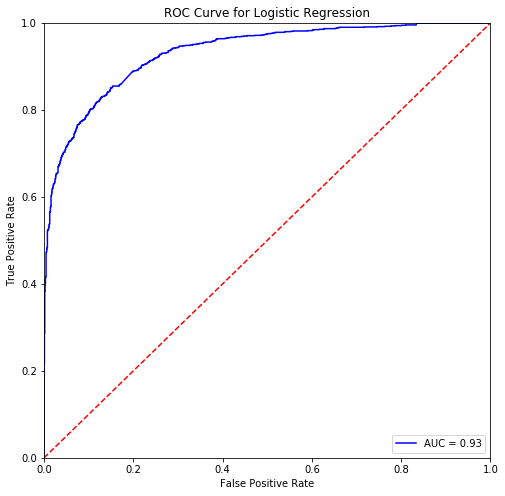

In [237]:
# ROC curve plot for Logictic Regression
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('ROC Curve for Logistic Regression')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

In [238]:
#building the k-nearest neighbors model
string = ''
vectorizer = TfidfVectorizer()
vectorize_text = vectorizer.fit_transform(X_train)
KNmodel = KNeighborsClassifier(n_neighbors=5)
KNmodel.fit(vectorize_text, y_train)

# score
vectorize_text = vectorizer.transform(X_test)
score = KNmodel.score(vectorize_text, y_test)
result_dict['K-Nearest'] = [score]
string += 'The k-nearest neighbors model has mean accuracy: ' + str(score)
print(string)

y_pred = KNmodel.predict(vectorize_text)
print('Confusion Matrix below : ')
metrics.confusion_matrix(y_test, y_pred)

The k-nearest neighbors model has mean accuracy: 0.6446969696969697
Confusion Matrix below : 


array([[1008,  287],
       [ 651,  694]], dtype=int64)

In [239]:
# analyzing the metrics
probs = KNmodel.predict_proba(vectorize_text)
preds = probs[:,0]
y_new_test = label_binarize(y_test, classes=['spam', 'ham'])
fpr, tpr, threshold = metrics.roc_curve(y_new_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
result_dict['K-Nearest'].append(roc_auc)
print('AUC for k-nearest neighbors is', roc_auc)

AUC for k-nearest neighbors is 0.723062967375235


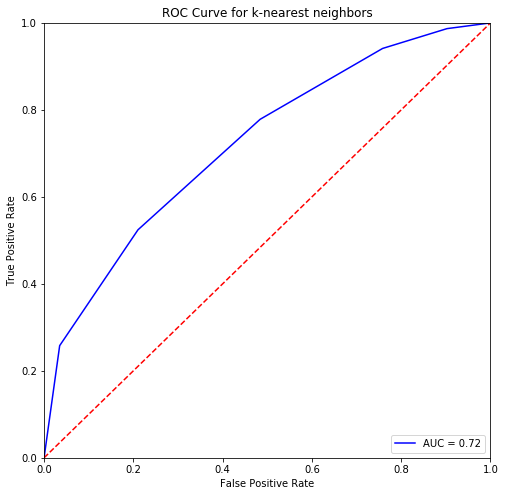

In [240]:
# ROC curve plot for k-nearest neighbors
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('ROC Curve for k-nearest neighbors')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

In [241]:
#building the Multinomial Naive Bayes model
string = ''
vectorizer = TfidfVectorizer()
vectorize_text = vectorizer.fit_transform(X_train)
MNBmodel = MultinomialNB()
MNBmodel.fit(vectorize_text, y_train)

# score
vectorize_text = vectorizer.transform(X_test)
score = MNBmodel.score(vectorize_text, y_test)
result_dict['Multinomial Naive Bayes'] = [score]
string += 'The Multinomial Naive Bayes Model has mean accuracy: ' + str(score)
print(string)

y_pred = MNBmodel.predict(vectorize_text)
print('Confusion Matrix below : ')
metrics.confusion_matrix(y_test, y_pred)

The Multinomial Naive Bayes Model has mean accuracy: 0.8321969696969697
Confusion Matrix below : 


array([[1168,  127],
       [ 316, 1029]], dtype=int64)

In [242]:
# analyzing the metrics
probs = MNBmodel.predict_proba(vectorize_text)
preds = probs[:,0]
y_new_test = label_binarize(y_test, classes=['spam', 'ham'])
fpr, tpr, threshold = metrics.roc_curve(y_new_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
result_dict['Multinomial Naive Bayes'].append(roc_auc)
print('AUC for Multinomial Naive Bayes is', roc_auc)

AUC for Multinomial Naive Bayes is 0.9317193667379542


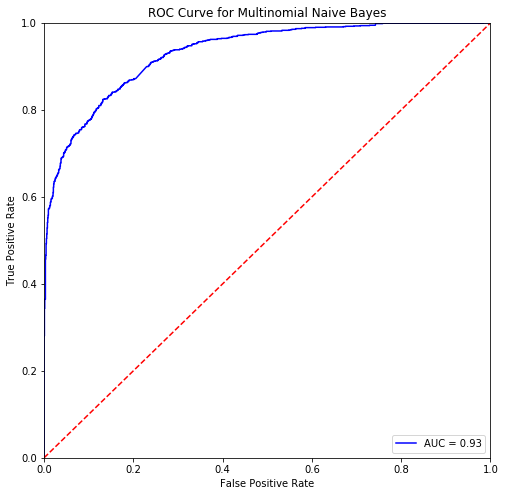

In [243]:
# ROC curve plot for Multinomial Naive Bayes
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('ROC Curve for Multinomial Naive Bayes')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

In [244]:
result_dict

{'Logistic Regression': [0.8492424242424242, 0.9322969384679423],
 'K-Nearest': [0.6446969696969697, 0.723062967375235],
 'Multinomial Naive Bayes': [0.8321969696969697, 0.9317193667379542]}

In [245]:
res_df = pandas.DataFrame.from_dict(result_dict, orient= 'index', columns=['Mean Accuracy', 'AUC'])
res_df

,Mean Accuracy,AUC
Logistic Regression,0.849242,0.932297
K-Nearest,0.644697,0.723063
Multinomial Naive Bayes,0.832197,0.931719


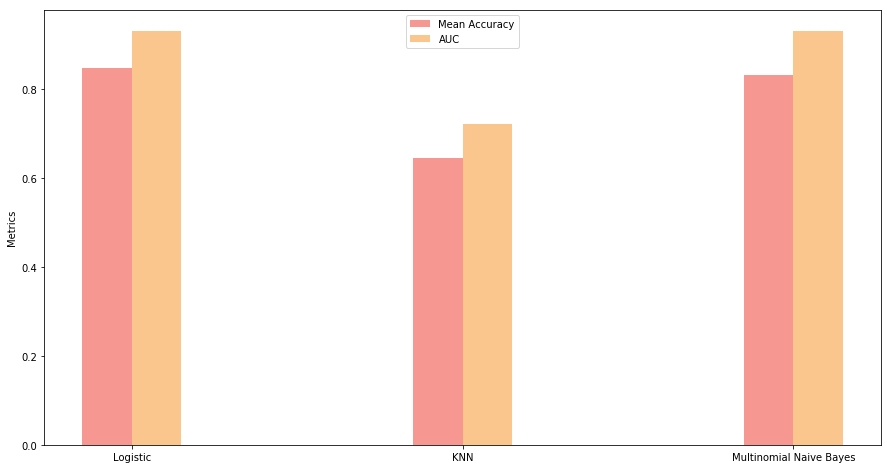

In [246]:
pos = list(range(len(res_df['Mean Accuracy']))) 
width = 0.15
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, 
        res_df['Mean Accuracy'],
        width, 
        alpha=0.5, 
        color='#EE3224',
       )

plt.bar([p + width for p in pos], 
        res_df['AUC'],
        width,
        alpha=0.5, 
        color='#F78F1E')

ax.set_ylabel('Metrics')

ax.set_xticks([ p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Logistic' , 'KNN', 'Multinomial Naive Bayes'])

plt.legend(['Mean Accuracy', 'AUC'], loc='upper center')
plt.show()
